In the study [A standardized and reproducible method to measure decision-making in mice](https://doi.org/10.1101/2020.01.17.909838), we show that the animal behavior in a visual decision-making task is similar across 9 labs in 7 institutions across 3 countries, when using a standardized, reproduciable experimental hardware, software, and procedures.

This notebook replicates Figure 2, which shows a similar learning rate of animals across different labs.
The notebook is generated based on [this repository](https://github.com/int-brain-lab/paper-behavior), which allows figure replications on a local machine.

# Import modules

To start with, we import some modules that will be used in the rest of the notebook:

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

We also import modules that allow us to interact with the schemas and tables in the IBL DataJoint pipeline.

In [2]:
import datajoint as dj
from ibl_pipeline import reference, subject
from ibl_pipeline.analyses import behavior as behavioral_analyses

Connecting dbadmin@datajoint-public.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as vathes


`reference` schema contains lab, user and project information
`subject` schema contains information of subject 
`behavior_analyses` schema contains results of standardized analyses, including the training status

Here are some modules that we pre-defined figure settings:

In [3]:
from paper_behavior_functions import (query_subjects, seaborn_style,
                                      group_colors, institution_map, seaborn_style)

# Initialize figure settings

In [4]:
seaborn_style()
pal = group_colors()
institution_map, col_names = institution_map()
col_names = col_names[:-1]

<Figure size 432x288 with 0 Axes>

# Query subjects that are trained

We pre-selected the "trained" animals based on the following criteria and save their uuids in the file `uuids_trained1.npy`
- 0% and 6% contrasts had been introduced to the contrast set.   
- 200 trials were completed with >80% performance on easy (100% and 50% contrasts) trials in each of the last three sessions. 
- A four-parameter psychometric curve (bias, lapse left, lapse right, threshold) fitted to performance on all trials from the last three sessions had parameter values of bias < 16, threshold < 19, and lapses < 0.2.


In [5]:
uuids = np.load('uuids_trained1.npy', allow_pickle=True)

We could then fetch the animals with their uuids:

In [6]:
subjects = subject.Subject & [{'subject_uuid': uuid} for uuid in uuids]

These are the 101 subjects reported in this study:

In [7]:
subjects

subject_uuid,subject_nickname nickname,sex sex,subject_birth_date birth date,ear_mark ear mark,subject_line name,subject_source name of source,protocol_number protocol number,subject_description,subject_ts
00778394-c956-408d-8a6c-ca3b05a611d5,KS019,F,2019-04-30,None,C57BL/6J,None,3,None,2020-01-13 23:39:00
019a22c1-b944-4494-9e38-0e45ae6697bf,SWC_022,M,2019-06-18,NA (Front HP),C57BL/6J,Charles River,4,ID: 990762,2020-01-13 23:39:01
02120449-9b19-4276-a434-513886c2fb19,ibl_witten_07,F,2018-11-13,None,C57BL/6J,Jax,3,None,2020-01-13 23:39:01
034fd43f-ee35-450b-99ef-25475ce25fdc,ZM_1092,M,2018-10-23,RLF,C57BL/6J,Jax,3,None,2020-01-13 23:39:02
05e97eea-64e2-4e52-a78a-5b78875b4fa3,KS004,F,2018-12-04,None,C57BL/6J,None,3,None,2020-01-13 23:39:03
0932d382-3fd4-4688-88d1-a0156cadd488,CSH_ZAD_007,M,2019-05-06,L,C57BL/6J,Jax,3,None,2020-01-13 23:39:05
0936a724-2151-446f-98b2-92c3e9dd36dc,CSHL_007,F,2018-11-27,L,C57BL/6J,Jax,3,None,2020-01-13 23:39:05
0fbb1324-1ac7-445a-8831-8fc2225338ca,CSH_ZAD_010,M,2019-05-06,none,C57BL/6J,Jax,3,None,2020-01-13 23:39:07
10fd3170-6c52-4cb6-986f-aa73704277c0,CSHL_015,F,2019-02-19,None,C57BL/6J,Jax,3,None,2019-09-18 01:17:36
13e59361-a2e8-4e2d-8636-ae0961fd941c,ZM_1093,M,2018-10-23,None,C57BL/6J,Jax,3,None,2020-01-13 23:39:10


To include all information that are needed for subjects, we pre-queried subjects with the function `query_subject`.

In [8]:
use_subjects = query_subjects()
use_subjects

subject_uuid,lab_name name of lab,subject_project,subject_nickname nickname,institution_short,date_trained calculated attribute
00778394-c956-408d-8a6c-ca3b05a611d5,cortexlab,ibl_neuropixel_brainwide_01,KS019,UCL,2019-09-19
019a22c1-b944-4494-9e38-0e45ae6697bf,mrsicflogellab,ibl_neuropixel_brainwide_01,SWC_022,SWC,2019-09-26
02120449-9b19-4276-a434-513886c2fb19,wittenlab,ibl_neuropixel_brainwide_01,ibl_witten_07,Princeton,2019-05-24
034fd43f-ee35-450b-99ef-25475ce25fdc,mainenlab,ibl_neuropixel_brainwide_01,ZM_1092,CCU,2019-02-04
05e97eea-64e2-4e52-a78a-5b78875b4fa3,cortexlab,ibl_neuropixel_brainwide_01,KS004,UCL,2019-06-06
0932d382-3fd4-4688-88d1-a0156cadd488,zadorlab,ibl_neuropixel_brainwide_01,CSH_ZAD_007,CSHL,2019-08-22
0936a724-2151-446f-98b2-92c3e9dd36dc,churchlandlab,ibl_neuropixel_brainwide_01,CSHL_007,CSHL,2019-03-19
0fbb1324-1ac7-445a-8831-8fc2225338ca,zadorlab,ibl_neuropixel_brainwide_01,CSH_ZAD_010,CSHL,2019-08-27
10fd3170-6c52-4cb6-986f-aa73704277c0,churchlandlab,ibl_neuropixel_brainwide_01,CSHL_015,CSHL,2019-07-08
13e59361-a2e8-4e2d-8636-ae0961fd941c,mainenlab,ibl_neuropixel_brainwide_01,ZM_1093,CCU,2019-02-05


One important field used in Fig2 in this table is `date_trained`, which is the first date that the animal reached the trained criteria.

# Fetch data from the trained animals as a data frame

The summary statistics of the behavior are processed and saved in `behavior_analyses.BehavioralSummaryByDate`:

In [9]:
behavioral_analyses.BehavioralSummaryByDate()

subject_uuid,session_date date of recording,performance percentage correct for the day,performance_easy percentage correct of the easy trials for the day,n_trials_date total number of trials on the date,training_day days since training,training_week weeks since training
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10,0.367347,0.367347,196,0,0
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12,0.4,0.4,140,1,0
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13,0.408072,0.408072,223,2,0
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14,0.453488,0.453488,344,3,0
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15,0.425532,0.425532,141,4,0
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16,0.467647,0.467647,340,5,1
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19,0.424107,0.424107,224,6,1
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20,0.440476,0.440476,252,7,1
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21,0.315985,0.315985,269,8,1
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-22,0.482812,0.482812,640,9,1


- performance: the correct rate on all trials of the date
- performance_easy: the correct rate on easy trials that contrast is greater than 50%
- n_trials_date: totoal number of trials on the date
- training_day: days since the animal is in training, starting from zero. 
- training_week: days since the animal is in training, starting from zero.

Join the BehavioralSummaryByDate table with subject query to gather info together:

In [10]:
b = behavioral_analyses.BehavioralSummaryByDate * use_subjects
b

subject_uuid,session_date date of recording,lab_name name of lab,subject_project,performance percentage correct for the day,performance_easy percentage correct of the easy trials for the day,n_trials_date total number of trials on the date,training_day days since training,training_week weeks since training,subject_nickname nickname,institution_short,date_trained calculated attribute
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10,cortexlab,ibl_neuropixel_brainwide_01,0.367347,0.367347,196,0,0,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12,cortexlab,ibl_neuropixel_brainwide_01,0.4,0.4,140,1,0,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13,cortexlab,ibl_neuropixel_brainwide_01,0.408072,0.408072,223,2,0,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14,cortexlab,ibl_neuropixel_brainwide_01,0.453488,0.453488,344,3,0,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-15,cortexlab,ibl_neuropixel_brainwide_01,0.425532,0.425532,141,4,0,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-16,cortexlab,ibl_neuropixel_brainwide_01,0.467647,0.467647,340,5,1,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-19,cortexlab,ibl_neuropixel_brainwide_01,0.424107,0.424107,224,6,1,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-20,cortexlab,ibl_neuropixel_brainwide_01,0.440476,0.440476,252,7,1,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-21,cortexlab,ibl_neuropixel_brainwide_01,0.315985,0.315985,269,8,1,KS019,UCL,2019-09-19
00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-22,cortexlab,ibl_neuropixel_brainwide_01,0.482812,0.482812,640,9,1,KS019,UCL,2019-09-19


Then we could fetch the contents in the table and return the data as a data frame:

In [11]:
behav = b.fetch(order_by='institution_short, subject_nickname, training_day',
                format='frame').reset_index()
behav['institution_code'] = behav.institution_short.map(institution_map)
behav

,subject_uuid,session_date,lab_name,subject_project,performance,performance_easy,n_trials_date,training_day,training_week,subject_nickname,institution_short,date_trained,institution_code
0,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-04,danlab,ibl_neuropixel_brainwide_01,0.420108,0.420108,557,0,0,DY_001,Berkeley,2019-03-11,Lab 7
1,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-05,danlab,ibl_neuropixel_brainwide_01,0.536932,0.536932,352,1,0,DY_001,Berkeley,2019-03-11,Lab 7
2,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-06,danlab,ibl_neuropixel_brainwide_01,0.510791,0.510791,417,2,0,DY_001,Berkeley,2019-03-11,Lab 7
3,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-07,danlab,ibl_neuropixel_brainwide_01,0.791866,0.791866,418,3,0,DY_001,Berkeley,2019-03-11,Lab 7
4,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-08,danlab,ibl_neuropixel_brainwide_01,0.925754,0.949254,431,4,0,DY_001,Berkeley,2019-03-11,Lab 7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-04,cortexlab,ibl_neuropixel_brainwide_01,0.767230,0.993151,769,18,3,KS025,UCL,2019-10-11,Lab 1
5134,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-05,cortexlab,ibl_neuropixel_brainwide_01,0.762032,0.991453,1122,19,3,KS025,UCL,2019-10-11,Lab 1
5135,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-07,cortexlab,ibl_neuropixel_brainwide_01,0.722429,0.992857,807,20,4,KS025,UCL,2019-10-11,Lab 1
5136,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-08,cortexlab,ibl_neuropixel_brainwide_01,0.777219,1.000000,597,21,4,KS025,UCL,2019-10-11,Lab 1


 Now compute how many mice are there for each institution and add the column to the dataframe

In [12]:
N = behav.groupby(['institution_code'])['subject_nickname'].nunique().to_dict()
behav['n_mice'] = behav.institution_code.map(N)
behav['institution_name'] = behav.institution_code + \
    ': ' + behav.n_mice.apply(str) + ' mice'
behav

,subject_uuid,session_date,lab_name,subject_project,performance,performance_easy,n_trials_date,training_day,training_week,subject_nickname,institution_short,date_trained,institution_code,n_mice,institution_name
0,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-04,danlab,ibl_neuropixel_brainwide_01,0.420108,0.420108,557,0,0,DY_001,Berkeley,2019-03-11,Lab 7,9,Lab 7: 9 mice
1,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-05,danlab,ibl_neuropixel_brainwide_01,0.536932,0.536932,352,1,0,DY_001,Berkeley,2019-03-11,Lab 7,9,Lab 7: 9 mice
2,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-06,danlab,ibl_neuropixel_brainwide_01,0.510791,0.510791,417,2,0,DY_001,Berkeley,2019-03-11,Lab 7,9,Lab 7: 9 mice
3,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-07,danlab,ibl_neuropixel_brainwide_01,0.791866,0.791866,418,3,0,DY_001,Berkeley,2019-03-11,Lab 7,9,Lab 7: 9 mice
4,bc381af7-631d-4ed0-95f9-8231c830158a,2019-03-08,danlab,ibl_neuropixel_brainwide_01,0.925754,0.949254,431,4,0,DY_001,Berkeley,2019-03-11,Lab 7,9,Lab 7: 9 mice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-04,cortexlab,ibl_neuropixel_brainwide_01,0.767230,0.993151,769,18,3,KS025,UCL,2019-10-11,Lab 1,16,Lab 1: 16 mice
5134,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-05,cortexlab,ibl_neuropixel_brainwide_01,0.762032,0.991453,1122,19,3,KS025,UCL,2019-10-11,Lab 1,16,Lab 1: 16 mice
5135,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-07,cortexlab,ibl_neuropixel_brainwide_01,0.722429,0.992857,807,20,4,KS025,UCL,2019-10-11,Lab 1,16,Lab 1: 16 mice
5136,5ba2da46-8213-4dd1-ac4e-3dc1eafd7141,2019-11-08,cortexlab,ibl_neuropixel_brainwide_01,0.777219,1.000000,597,21,4,KS025,UCL,2019-10-11,Lab 1,16,Lab 1: 16 mice


# Fig 2a, plot learning curves of animals in each of the institution

In Fig 2a, we plot the performance on easy trials `performance_easy` as a function of `training_day` for each animal in each institution.

For plotting purpose, we create another column only after the mouse is trained, and performance before the training date is marked as NaN:

In [13]:
behav2 = pd.DataFrame([])
for index, group in behav.groupby(['institution_code', 'subject_nickname']):
    group['performance_easy_trained'] = group.performance_easy
    group.loc[group['session_date'] < pd.to_datetime(group['date_trained']),
              'performance_easy_trained'] = np.nan
    # add this
    behav2 = behav2.append(group)
behav = behav2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


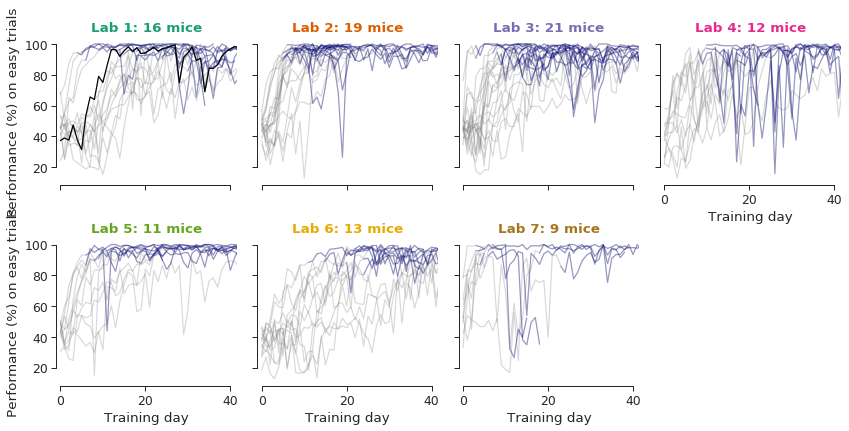

In [14]:
behav['performance_easy'] = behav.performance_easy * 100
behav['performance_easy_trained'] = behav.performance_easy_trained * 100

# plot one curve for each animal, one panel per lab
fig = sns.FacetGrid(behav,
                    col="institution_code", col_wrap=4, col_order=col_names,
                    sharex=True, sharey=True, aspect=1, hue="subject_uuid", xlim=[-1, 41.5])
fig.map(sns.lineplot, "training_day",
        "performance_easy", color='gray', alpha=0.3)
fig.map(sns.lineplot, "training_day",
        "performance_easy_trained", color='darkblue', alpha=0.3)
fig.set_titles("{col_name}")
for axidx, ax in enumerate(fig.axes.flat):
    ax.set_title(behav.institution_name.unique()[
                 axidx], color=pal[axidx], fontweight='bold')

# overlay the example mouse
sns.lineplot(ax=fig.axes[0], x='training_day', y='performance_easy', color='black',
             data=behav[behav['subject_nickname'].str.contains('KS014')], legend=False)

fig.set_axis_labels('Training day', 'Performance (%) on easy trials')
fig.despine(trim=True)

Performance on easy contrast trials (50% and 100% contrast) across mice and laboratories. Each panel represents a different lab, and each curve represents a mouse (gray). The transition from gray to blue indicates when performance criteria for "trained" are met. Black, performance for example mouse `KS014`

# Fig 2b - plot the learning curve averaged over animals for all institutions

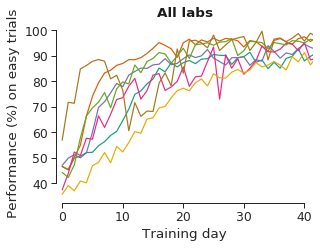

In [15]:
# Plot all labs
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
sns.lineplot(x='training_day', y='performance_easy', hue='institution_code', palette=pal,
             ax=ax1, legend=False, data=behav, ci=None)
ax1.set_title('All labs', color='k', fontweight='bold')
ax1.set(xlabel='Training day',
        ylabel='Performance (%) on easy trials', xlim=[-1, 41.5])

seaborn_style()
plt.tight_layout(pad=2)

# Print some statistics

In [16]:
behav_summary_std = behav.groupby(['training_day'])[
    'performance_easy'].std().reset_index()
behav_summary = behav.groupby(['training_day'])[
    'performance_easy'].mean().reset_index()
print('number of days to reach 80% accuracy on easy trials: ')
print(behav_summary.loc[behav_summary.performance_easy >
                        80, 'training_day'].min())

number of days to reach 80% accuracy on easy trials: 
14
